In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, balanced_accuracy_score,precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix,matthews_corrcoef
import sys 
import pickle
from rdkit import Chem
from rdkit.Chem import AllChem
from imblearn.under_sampling import RandomUnderSampler
sys.path.append('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/')
from RF_atomver import *
from VisUtils import *

In [2]:
def scaled_df_with_folds(file_path, file_name, fold):
    """Standard Scalar to normalize original dataset
    Scale data, put back feature names (including ID columns, add subset (train / test) column
    file_path: directory where file is located 
    file_name: should be NEK#_1_uM_min_50_pct_(binding/inhibition)_5fold_random_imbalanced.csv
    returns: final scaled dataframe
    """
    df_original = pd.read_csv(file_path+file_name)
    print(f'original shape: {df_original.shape}')
    df_original = df_original.drop_duplicates(subset='base_rdkit_smiles')
    print(f'remove duplicates: {df_original.shape}')

    id_cols = ['compound_id', 'base_rdkit_smiles', 'fold'] 
    active_col = ['active'] 
    exclude_cols = id_cols +active_col
    feature_cols = [col for col in df_original.columns if col not in exclude_cols]
    # feature_names = df_original.columns.difference(exclude_cols)
    
    original_cols = df_original.columns 
    og_cols = original_cols.to_list() 
    # feature_cols = og_cols[3:-1] 
    id_col_names = og_cols[0:2]
    id_cols = df_original[id_col_names]
    fold_col = df_original['fold']
    true_labels = df_original['active']
    # print(f'all cols: {original_cols.shape}, features: {len(feature_cols)}, id: {id_col_names}')
    train_df = df_original[df_original['fold']!=fold]
    test_df = df_original[df_original['fold']==fold]
    trainX_df = train_df[feature_cols]
    testX_df = test_df[feature_cols]
    trainy_df = train_df['active']
    testy_df = test_df['active']
    
    train_id_df = train_df[id_col_names]
    test_id_df = test_df[id_col_names]
    train_fold = train_df['fold']
    test_fold = test_df['fold']
    
    x_df = pd.concat([trainX_df, testX_df])
    scaling=StandardScaler()
    scaling.fit(x_df) 
    
    scaled_data=scaling.transform(x_df)
    trainX_scaled = scaling.transform(trainX_df)
    testX_scaled = scaling.transform(testX_df) 
    print(f'train X: {trainX_scaled.shape}, testX: {testX_scaled.shape}')
    trainX_final = pd.DataFrame(trainX_scaled, columns=feature_cols)
    trainX_final['subset'] = 'train'
    
    testX_final = pd.DataFrame(testX_scaled, columns=feature_cols)
    testX_final['subset']='test'
    trainX_final[id_col_names] = train_id_df.reset_index(drop=True)
    testX_final[id_col_names] = test_id_df.reset_index(drop=True)
    trainX_final['fold'] = train_fold.reset_index(drop=True)
    testX_final['fold'] = test_fold.reset_index(drop=True)
    
    trainX_final['active'] = trainy_df.reset_index(drop=True)
    testX_final['active'] = testy_df.reset_index(drop=True)

    final_df = pd.concat([trainX_final, testX_final], ignore_index=True)
    return final_df
    

In [3]:
def undersample(file_path, filename):
    """Undersample the datasetes using the RandomUndersampler
    Keeps the feature names and id cols
    file_name (full/absolute path): use the scaled dataframe we just created above 'NEK#_binding_moe_scaled_df.csv'
    returns: undersampled dataframe
    """

    df = pd.read_csv(file_path+filename)
    original_cols = df.columns.to_list() 
    id_cols = ['compound_id', 'base_rdkit_smiles', 'fold'] 
    active_col = ['active'] 
    exclude_cols = id_cols +active_col
    # feature_names = df.columns.difference(exclude_cols)
    feature_names = [col for col in df.columns if col not in exclude_cols]
    # feature_names = original_cols[0:-5]
    other_cols = original_cols[-5:]
    id_col_names = other_cols[0:4]
    id_cols = df[id_col_names]
    
    train_df = df[df['subset'] == 'train']
    test_df = df[df['subset'] == 'test']
    trainX = train_df[feature_names]
    testX = test_df[feature_names]
    trainy = train_df['active']
    testy = test_df['active']
    
    train_ids = train_df[id_col_names]
    test_ids = test_df[id_col_names]
    undersample = RandomUnderSampler(random_state=42)
    
    trainX_temp, trainy_temp = undersample.fit_resample(trainX.to_numpy(), trainy.to_numpy().reshape(-1))
    
    trainX_resamp = pd.DataFrame(trainX_temp, columns=feature_names)
    trainy_resamp = pd.DataFrame(trainy_temp, columns=['active'])
    
    train_ids_resamp = train_ids.iloc[trainX_resamp.index].reset_index(drop=True)
    train_resamp= pd.concat([train_ids_resamp, trainX_resamp,trainy_resamp], axis=1)
    train_resamp['subset'] = 'train'

    test_df_final = pd.concat([test_ids.reset_index(drop=True),testX.reset_index(drop=True),testy.reset_index(drop=True)],axis=1)
    test_df_final['subset'] = 'test'
    final_df = pd.concat([train_resamp,test_df_final]).reset_index(drop=True)
    return final_df 
        

In [4]:
def smiles_to_fps(smiles_list, radius=2, nBits=2048):
    fps = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
            arr = np.zeros((1,), dtype=np.int8)
            Chem.DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
    return np.array(fps)

def make_smiles(file_path, filename):
    """Create Morgan Fingerpint features from smiles srrings 
    file_path: directory of datafame
    filename: any dataframe with active, base_rdkit_smiles, fold, compound_id
    returns: final dataframe with morgan fingerprints based on the original dataframe's smiles strings 
    """
    df = pd.read_csv(file_path+filename)
    train_y = df[df['subset']=='train']['active']
    test_y=df[df['subset']=='test']['active']
    train_sm = df[df['subset']=='train']['base_rdkit_smiles']
    test_sm = df[df['subset']=='test']['base_rdkit_smiles']
    train_id = df[df['subset']=='train']['compound_id']
    test_id = df[df['subset']=='test']['compound_id']
    train_fold = df[df['subset']=='train']['fold']
    test_fold = df[df['subset']=='test']['fold']
    
    trainX_mfp = smiles_to_fps(train_sm, radius=2)
    testX_mfp = smiles_to_fps(test_sm, radius=2)
    
    trainX_mfp_df = pd.DataFrame(trainX_mfp)
    testX_mfp_df = pd.DataFrame(testX_mfp)
    
    trainX_mfp_df['subset'] = 'train'
    testX_mfp_df['subset'] = 'test'
    
    trainX_mfp_df['base_rdkit_smiles'] = train_sm.reset_index(drop=True)
    testX_mfp_df['base_rdkit_smiles'] = test_sm.reset_index(drop=True)
    trainX_mfp_df['compound_id'] = train_id.reset_index(drop=True)
    testX_mfp_df['compound_id'] = test_id.reset_index(drop=True)
    trainX_mfp_df['fold'] = train_fold.reset_index(drop=True)
    testX_mfp_df['fold'] = test_fold.reset_index(drop=True)
    
    trainX_mfp_df['active'] = train_y.reset_index(drop=True)
    testX_mfp_df['active'] = test_y.reset_index(drop=True)
    final_df = pd.concat([trainX_mfp_df,testX_mfp_df], ignore_index=True)
    return final_df
        

In [5]:
data_dir = '/Users/jayceepang/msse/capstone/data/NEK_ATOM_data/'
this_dir = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/undersampler_validation/idea5_dir/'
neks = ['2','3','5','9']
folds = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
for i, nek in enumerate(neks):
    if nek in ['2','9']: 
        bind_inhib = ['binding', 'inhibition']
    else: 
        bind_inhib = ['binding'] 
    for bi in bind_inhib: 
        if bi == 'binding': 
            this_bi = 'bind'
        else: 
            this_bi = 'inhib' 
        nek_path= f'{data_dir}NEK{nek}/'
        assay_file = f'NEK{nek}_1_uM_min_50_pct_{bi}_5fold_random_imbalanced.csv'
        print(nek, bi)
        for fold in folds: 
            final_df = scaled_df_with_folds(nek_path,assay_file, fold) 

            fold_dir = f'{this_dir}{fold}/'
            final_csv_name = f'NEK{nek}_{bi}_moe_scaled_df_{fold}.csv'
            final_mfp_csv_name= f'NEK{nek}_{bi}_mfp_scaled_df_{fold}.csv'
            final_df.to_csv(f'{fold_dir}{final_csv_name}', index=False)
            mfp_df = make_smiles(fold_dir, final_csv_name)
            mfp_df.to_csv(f'{fold_dir}{final_mfp_csv_name}', index=False)
            under_df = undersample(fold_dir, final_csv_name)
            under_df.to_csv(f'{fold_dir}NEK{nek}_{bi}_moe_UNDER_df_{fold}.csv',index=False)
            under_mfp_df = make_smiles(fold_dir, f'NEK{nek}_{bi}_moe_UNDER_df_{fold}.csv')
            under_mfp_df.to_csv(f'{fold_dir}NEK{nek}_{bi}_mfp_UNDER_df_{fold}.csv',index=False)

2 binding
original shape: (1408, 310)
remove duplicates: (1408, 310)
train X: (1125, 306), testX: (283, 306)
original shape: (1408, 310)
remove duplicates: (1408, 310)
train X: (1126, 306), testX: (282, 306)
original shape: (1408, 310)
remove duplicates: (1408, 310)
train X: (1127, 306), testX: (281, 306)
original shape: (1408, 310)
remove duplicates: (1408, 310)
train X: (1127, 306), testX: (281, 306)
original shape: (1408, 310)
remove duplicates: (1408, 310)
train X: (1127, 306), testX: (281, 306)
2 inhibition
original shape: (2044, 310)
remove duplicates: (2032, 310)
train X: (1624, 306), testX: (408, 306)
original shape: (2044, 310)
remove duplicates: (2032, 310)
train X: (1628, 306), testX: (404, 306)
original shape: (2044, 310)
remove duplicates: (2032, 310)
train X: (1625, 306), testX: (407, 306)
original shape: (2044, 310)
remove duplicates: (2032, 310)
train X: (1626, 306), testX: (406, 306)
original shape: (2044, 310)
remove duplicates: (2032, 310)
train X: (1625, 306), testX

In [6]:
def add_cm2(df): 
    true_labels = df['y'] 
    predictions = df['prediction']
    cm = confusion_matrix(true_labels, predictions )
    cm_flattened = cm.flatten().tolist()
    df['cm'] = [cm_flattened]* len(df)
    df['prediction_type'] = df.apply(lambda x: prediction_type(x['y'], x['prediction']), axis=1) 
    df['f1'] = f1_score(df['y'], df['prediction'])
    df['ROC-AUC'] = roc_auc_score(df['y'], df['prediction'])
    df['MCC'] = matthews_corrcoef(df['y'], df['prediction'])
    df['Balanced Accuracy'] = balanced_accuracy_score(df['y'], df['prediction'])
    return df

In [7]:
drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active'] 
save_path ='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/undersampler_validation/idea5_dir/'
for i, nek in enumerate(neks):
    if nek in ['2','9']: 
        bind_inhib = ['binding', 'inhibition']
    else: 
        bind_inhib = ['binding'] 
    for bi in bind_inhib: 
        if bi == 'binding': 
            this_bi = 'bind'
        else: 
            this_bi = 'inhib' 
        
        RF_type = 'RF'
        for feat in ['moe', 'mfp']: 
            for fold in folds: 
                print(f'NEK{nek} {bi} {feat}')
                fold_dir = f'{this_dir}{fold}/'
                df = pd.read_csv(f'{fold_dir}NEK{nek}_{bi}_{feat}_UNDER_df_{fold}.csv')
                
                trainX = df[df['subset'] == 'train'] 
                train_y = trainX['active'].to_numpy() 
                if 'subset.1' in trainX.columns: 
                    drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active', 'subset.1']
                else: 
                    drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active'] 
                trainX = trainX.drop(columns=drop_cols).to_numpy()
                
                testX = df[df['subset'] == 'test'] 
                test_y = testX['active'].to_numpy()
                if 'subset.1' in testX.columns: 
                    drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active', 'subset.1'] 
                else: 
                    drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active'] 
                testX = testX.drop(columns=drop_cols).to_numpy()
                model = rf_models(trainX, train_y, testX, test_y, RF_type, {})
                train_df = gather_rf_results(model, trainX, train_y)
                test_df = gather_rf_results(model, testX, test_y)
                train_df['subset'] = 'train' 
                test_df['subset'] = 'test' 
                model_name = f'NEK{nek}_{bi}_{feat}_UNDER_RF_{fold}' 
                train_df['model'] = model_name
                test_df['model'] = model_name
                train_df = add_cm2(train_df)
                test_df = add_cm2(test_df)
                
                train_df['NEK'] = f'NEK{nek}_{bi}'
                train_df['feat_type'] = feat
                train_df['strategy'] = 'UNDER'
                train_df['RF_type'] = RF_type
                test_df['NEK'] = f'NEK{nek}_{bi}'
                test_df['feat_type'] = feat
                test_df['strategy'] = 'UNDER'
                test_df['RF_type'] = RF_type
                test_df['train_fold'] = fold
                train_df['train_fold'] = fold
                
                with open(f'{fold_dir}{model_name}.pkl', 'wb') as f: 
                    pickle.dump(model,f)
        
                train_df.to_csv(f'{fold_dir}{model_name}_train_results.csv',index=False) 
                test_df.to_csv(f'{fold_dir}{model_name}_test_results.csv',index=False) 
                

NEK2 binding moe
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.558, precision: 0.069, recall: 0.750, specificity: 0.550
NEK2 binding moe
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.582, precision: 0.073, recall: 0.750, specificity: 0.574
NEK2 binding moe
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.648, precision: 0.085, recall: 0.818, specificity: 0.641
NEK2 binding moe
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.505, precision: 0.036, recall: 0.455, specificity: 0.507
NEK2 binding moe
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.669, precision: 0.082, recall: 0.727, specificity: 0.667
NEK2 binding mfp
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.625, precision: 0.057, recall: 0.500, specificity

In [8]:
for i, nek in enumerate(neks):
    if nek in ['2','9']: 
        bind_inhib = ['binding', 'inhibition']
    else: 
        bind_inhib = ['binding'] 
    for bi in bind_inhib: 
        if bi == 'binding': 
            this_bi = 'bind'
        else: 
            this_bi = 'inhib' 
        for rf in ['BRFC', 'BRFC_BCW']: 
            for feat in ['moe', 'mfp']: 
                for fold in folds: 
                    print(f'NEK{nek} {bi} {feat}')
                    fold_dir = f'{this_dir}{fold}/'
                    df = pd.read_csv(f'{fold_dir}NEK{nek}_{bi}_{feat}_scaled_df_{fold}.csv')
                    trainX = df[df['subset'] == 'train'] 
                    train_y = trainX['active'].to_numpy() 
                    if 'subset.1' in trainX.columns: 
                        drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active', 'subset.1']
                    else: 
                        drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active'] 
                    trainX = trainX.drop(columns=drop_cols).to_numpy()
                    
                    testX = df[df['subset'] == 'test'] 
                    test_y = testX['active'].to_numpy()
                    if 'subset.1' in testX.columns: 
                        drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active', 'subset.1'] 
                    else: 
                        drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active'] 
                    testX = testX.drop(columns=drop_cols).to_numpy()
                    model = rf_models(trainX, train_y, testX, test_y, rf, {})
                    train_df = gather_rf_results(model, trainX, train_y)
                    test_df = gather_rf_results(model, testX, test_y)
                    train_df['subset'] = 'train' 
                    test_df['subset'] = 'test' 
                    model_name = f'NEK{nek}_{bi}_{feat}_raw_{rf}_{fold}' 
                    train_df['model'] = model_name
                    test_df['model'] = model_name
                    train_df = add_cm2(train_df)
                    test_df = add_cm2(test_df)
                    train_df['NEK'] = f'NEK{nek}_{bi}'
                    train_df['feat_type'] = feat
                    train_df['strategy'] = 'raw'
                    train_df['RF_type'] = rf
                    test_df['NEK'] = f'NEK{nek}_{bi}'
                    test_df['feat_type'] = feat
                    test_df['strategy'] = 'raw'
                    test_df['RF_type'] = rf
                    test_df['train_fold'] = fold
                    train_df['train_fold'] = fold
                    with open(f'{fold_dir}{model_name}.pkl', 'wb') as f: 
                        pickle.dump(model,f)
                    train_df.to_csv(f'{fold_dir}{model_name}_train_results.csv',index=False) 
                    test_df.to_csv(f'{fold_dir}{model_name}_test_results.csv',index=False) 

NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.738, precision: 0.132, recall: 1.000, specificity: 0.727
TEST: accuracy: 0.760, precision: 0.088, recall: 0.500, specificity: 0.771
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.734, precision: 0.131, recall: 1.000, specificity: 0.723
TEST: accuracy: 0.720, precision: 0.096, recall: 0.667, specificity: 0.722
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.785, precision: 0.160, recall: 1.000, specificity: 0.776
TEST: accuracy: 0.772, precision: 0.092, recall: 0.545, specificity: 0.781
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.759, precision: 0.145, recall: 1.000, specificity: 0.748
TEST: accuracy: 0.658, precision: 0.071, recall: 0.636, specificity: 0.659
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.776, precision: 0.154, recall: 1.000, specificity: 0.767
TEST: accuracy: 0.722, precision: 0.086, recall: 0.636, specificity: 0.726
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.825, precision: 0.186, recall: 1.000, specificity: 0.818
TEST: accuracy: 0.813, precision: 0.127, recall: 0.583, specificity: 0.823
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.805, precision: 0.170, recall: 1.000, specificity: 0.796
TEST: accuracy: 0.745, precision: 0.115, recall: 0.750, specificity: 0.744
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.817, precision: 0.183, recall: 1.000, specificity: 0.809
TEST: accuracy: 0.786, precision: 0.111, recall: 0.636, specificity: 0.793
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.838, precision: 0.201, recall: 1.000, specificity: 0.831
TEST: accuracy: 0.747, precision: 0.105, recall: 0.727, specificity: 0.748
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.810, precision: 0.177, recall: 1.000, specificity: 0.802
TEST: accuracy: 0.794, precision: 0.138, recall: 0.818, specificity: 0.793
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.709, precision: 0.121, recall: 1.000, specificity: 0.697
TEST: accuracy: 0.693, precision: 0.088, recall: 0.667, specificity: 0.694
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.658, precision: 0.105, recall: 1.000, specificity: 0.644
TEST: accuracy: 0.660, precision: 0.071, recall: 0.583, specificity: 0.663
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.687, precision: 0.115, recall: 1.000, specificity: 0.673
TEST: accuracy: 0.637, precision: 0.058, recall: 0.545, specificity: 0.641
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.687, precision: 0.115, recall: 1.000, specificity: 0.673
TEST: accuracy: 0.641, precision: 0.067, recall: 0.636, specificity: 0.641
NEK2 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.689, precision: 0.116, recall: 1.000, specificity: 0.675
TEST: accuracy: 0.605, precision: 0.061, recall: 0.636, specificity: 0.604
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.492, precision: 0.073, recall: 1.000, specificity: 0.470
TEST: accuracy: 0.488, precision: 0.071, recall: 0.917, specificity: 0.469
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.513, precision: 0.076, recall: 1.000, specificity: 0.493
TEST: accuracy: 0.443, precision: 0.050, recall: 0.667, specificity: 0.433
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.474, precision: 0.072, recall: 1.000, specificity: 0.451
TEST: accuracy: 0.445, precision: 0.061, recall: 0.909, specificity: 0.426
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.527, precision: 0.079, recall: 1.000, specificity: 0.507
TEST: accuracy: 0.452, precision: 0.061, recall: 0.909, specificity: 0.433
NEK2 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.543, precision: 0.082, recall: 1.000, specificity: 0.524
TEST: accuracy: 0.477, precision: 0.034, recall: 0.455, specificity: 0.478
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.900, precision: 0.409, recall: 1.000, specificity: 0.893
TEST: accuracy: 0.897, precision: 0.370, recall: 0.714, specificity: 0.911
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.917, precision: 0.453, recall: 1.000, specificity: 0.911
TEST: accuracy: 0.876, precision: 0.338, recall: 0.821, specificity: 0.880
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.905, precision: 0.421, recall: 1.000, specificity: 0.898
TEST: accuracy: 0.855, precision: 0.304, recall: 0.857, specificity: 0.855
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.909, precision: 0.431, recall: 1.000, specificity: 0.902
TEST: accuracy: 0.857, precision: 0.286, recall: 0.714, specificity: 0.868
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.910, precision: 0.434, recall: 1.000, specificity: 0.904
TEST: accuracy: 0.870, precision: 0.319, recall: 0.786, specificity: 0.876
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.908, precision: 0.427, recall: 1.000, specificity: 0.901
TEST: accuracy: 0.892, precision: 0.357, recall: 0.714, specificity: 0.905
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.921, precision: 0.465, recall: 1.000, specificity: 0.915
TEST: accuracy: 0.916, precision: 0.444, recall: 0.857, specificity: 0.920
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.919, precision: 0.461, recall: 1.000, specificity: 0.913
TEST: accuracy: 0.867, precision: 0.329, recall: 0.893, specificity: 0.865
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.904, precision: 0.418, recall: 1.000, specificity: 0.897
TEST: accuracy: 0.889, precision: 0.373, recall: 0.893, specificity: 0.889
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.900, precision: 0.407, recall: 1.000, specificity: 0.892
TEST: accuracy: 0.882, precision: 0.348, recall: 0.821, specificity: 0.887
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.852, precision: 0.318, recall: 1.000, specificity: 0.841
TEST: accuracy: 0.826, precision: 0.241, recall: 0.714, specificity: 0.834
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.838, precision: 0.299, recall: 1.000, specificity: 0.827
TEST: accuracy: 0.792, precision: 0.225, recall: 0.821, specificity: 0.790
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.858, precision: 0.327, recall: 1.000, specificity: 0.847
TEST: accuracy: 0.818, precision: 0.239, recall: 0.750, specificity: 0.823
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.858, precision: 0.327, recall: 1.000, specificity: 0.847
TEST: accuracy: 0.818, precision: 0.244, recall: 0.786, specificity: 0.820
NEK2 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.862, precision: 0.332, recall: 1.000, specificity: 0.851
TEST: accuracy: 0.794, precision: 0.214, recall: 0.750, specificity: 0.797
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.767, precision: 0.228, recall: 1.000, specificity: 0.749
TEST: accuracy: 0.743, precision: 0.202, recall: 0.929, specificity: 0.729
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.752, precision: 0.217, recall: 1.000, specificity: 0.734
TEST: accuracy: 0.718, precision: 0.188, recall: 0.929, specificity: 0.702
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.775, precision: 0.235, recall: 1.000, specificity: 0.759
TEST: accuracy: 0.708, precision: 0.168, recall: 0.821, specificity: 0.699
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.775, precision: 0.234, recall: 1.000, specificity: 0.758
TEST: accuracy: 0.719, precision: 0.193, recall: 0.964, specificity: 0.701
NEK2 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.768, precision: 0.229, recall: 1.000, specificity: 0.751
TEST: accuracy: 0.715, precision: 0.181, recall: 0.893, specificity: 0.702
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.751, precision: 0.187, recall: 1.000, specificity: 0.736
TEST: accuracy: 0.667, precision: 0.119, recall: 0.706, specificity: 0.664
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.777, precision: 0.206, recall: 1.000, specificity: 0.764
TEST: accuracy: 0.740, precision: 0.110, recall: 0.500, specificity: 0.755
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.776, precision: 0.206, recall: 1.000, specificity: 0.763
TEST: accuracy: 0.680, precision: 0.130, recall: 0.812, specificity: 0.672
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.750, precision: 0.188, recall: 1.000, specificity: 0.735
TEST: accuracy: 0.718, precision: 0.154, recall: 0.875, specificity: 0.708
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.748, precision: 0.187, recall: 1.000, specificity: 0.733
TEST: accuracy: 0.618, precision: 0.097, recall: 0.688, specificity: 0.614
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.815, precision: 0.235, recall: 1.000, specificity: 0.803
TEST: accuracy: 0.784, precision: 0.145, recall: 0.529, specificity: 0.800
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.805, precision: 0.229, recall: 1.000, specificity: 0.793
TEST: accuracy: 0.783, precision: 0.131, recall: 0.500, specificity: 0.800
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.792, precision: 0.217, recall: 1.000, specificity: 0.779
TEST: accuracy: 0.722, precision: 0.140, recall: 0.750, specificity: 0.721
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.794, precision: 0.219, recall: 1.000, specificity: 0.781
TEST: accuracy: 0.725, precision: 0.114, recall: 0.562, specificity: 0.735
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.770, precision: 0.201, recall: 1.000, specificity: 0.756
TEST: accuracy: 0.764, precision: 0.171, recall: 0.812, specificity: 0.761
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.637, precision: 0.136, recall: 1.000, specificity: 0.615
TEST: accuracy: 0.603, precision: 0.107, recall: 0.765, specificity: 0.592
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.683, precision: 0.154, recall: 1.000, specificity: 0.664
TEST: accuracy: 0.641, precision: 0.062, recall: 0.375, specificity: 0.657
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.675, precision: 0.151, recall: 1.000, specificity: 0.655
TEST: accuracy: 0.641, precision: 0.079, recall: 0.500, specificity: 0.649
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.711, precision: 0.167, recall: 1.000, specificity: 0.693
TEST: accuracy: 0.654, precision: 0.091, recall: 0.562, specificity: 0.659
NEK3 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.681, precision: 0.154, recall: 1.000, specificity: 0.662
TEST: accuracy: 0.579, precision: 0.089, recall: 0.688, specificity: 0.572
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.638, precision: 0.136, recall: 1.000, specificity: 0.616
TEST: accuracy: 0.631, precision: 0.078, recall: 0.471, specificity: 0.642
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.641, precision: 0.139, recall: 1.000, specificity: 0.619
TEST: accuracy: 0.648, precision: 0.097, recall: 0.625, specificity: 0.649
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.614, precision: 0.130, recall: 1.000, specificity: 0.590
TEST: accuracy: 0.548, precision: 0.089, recall: 0.750, specificity: 0.536
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.609, precision: 0.129, recall: 1.000, specificity: 0.585
TEST: accuracy: 0.511, precision: 0.094, recall: 0.875, specificity: 0.489
NEK3 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.639, precision: 0.138, recall: 1.000, specificity: 0.617
TEST: accuracy: 0.607, precision: 0.108, recall: 0.812, specificity: 0.595
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.839, precision: 0.326, recall: 1.000, specificity: 0.826
TEST: accuracy: 0.778, precision: 0.231, recall: 0.750, specificity: 0.781
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.843, precision: 0.332, recall: 1.000, specificity: 0.830
TEST: accuracy: 0.770, precision: 0.224, recall: 0.750, specificity: 0.772
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.849, precision: 0.344, recall: 1.000, specificity: 0.837
TEST: accuracy: 0.717, precision: 0.177, recall: 0.737, specificity: 0.715
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.835, precision: 0.324, recall: 1.000, specificity: 0.821
TEST: accuracy: 0.749, precision: 0.169, recall: 0.579, specificity: 0.763
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.846, precision: 0.339, recall: 1.000, specificity: 0.833
TEST: accuracy: 0.781, precision: 0.193, recall: 0.579, specificity: 0.798
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.853, precision: 0.347, recall: 1.000, specificity: 0.841
TEST: accuracy: 0.819, precision: 0.273, recall: 0.750, specificity: 0.825
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.889, precision: 0.412, recall: 1.000, specificity: 0.879
TEST: accuracy: 0.835, precision: 0.294, recall: 0.750, specificity: 0.842
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.856, precision: 0.353, recall: 1.000, specificity: 0.843
TEST: accuracy: 0.785, precision: 0.250, recall: 0.895, specificity: 0.776
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.874, precision: 0.384, recall: 1.000, specificity: 0.863
TEST: accuracy: 0.842, precision: 0.300, recall: 0.789, specificity: 0.846
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.876, precision: 0.388, recall: 1.000, specificity: 0.865
TEST: accuracy: 0.826, precision: 0.260, recall: 0.684, specificity: 0.838
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.737, precision: 0.228, recall: 1.000, specificity: 0.715
TEST: accuracy: 0.657, precision: 0.143, recall: 0.650, specificity: 0.658
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.745, precision: 0.234, recall: 1.000, specificity: 0.724
TEST: accuracy: 0.681, precision: 0.161, recall: 0.700, specificity: 0.680
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.742, precision: 0.234, recall: 1.000, specificity: 0.720
TEST: accuracy: 0.688, precision: 0.163, recall: 0.737, specificity: 0.684
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.773, precision: 0.257, recall: 1.000, specificity: 0.753
TEST: accuracy: 0.652, precision: 0.076, recall: 0.316, specificity: 0.680
NEK5 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.785, precision: 0.268, recall: 1.000, specificity: 0.766
TEST: accuracy: 0.765, precision: 0.180, recall: 0.579, specificity: 0.781
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.717, precision: 0.216, recall: 1.000, specificity: 0.693
TEST: accuracy: 0.685, precision: 0.185, recall: 0.850, specificity: 0.671
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.784, precision: 0.265, recall: 1.000, specificity: 0.765
TEST: accuracy: 0.710, precision: 0.167, recall: 0.650, specificity: 0.715
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.720, precision: 0.220, recall: 1.000, specificity: 0.696
TEST: accuracy: 0.611, precision: 0.153, recall: 0.895, specificity: 0.588
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.740, precision: 0.233, recall: 1.000, specificity: 0.718
TEST: accuracy: 0.692, precision: 0.165, recall: 0.737, specificity: 0.689
NEK5 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.754, precision: 0.242, recall: 1.000, specificity: 0.732
TEST: accuracy: 0.676, precision: 0.141, recall: 0.632, specificity: 0.680
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.755, precision: 0.148, recall: 1.000, specificity: 0.744
TEST: accuracy: 0.731, precision: 0.111, recall: 0.692, specificity: 0.733
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.735, precision: 0.141, recall: 1.000, specificity: 0.723
TEST: accuracy: 0.660, precision: 0.088, recall: 0.750, specificity: 0.656
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.723, precision: 0.136, recall: 1.000, specificity: 0.711
TEST: accuracy: 0.684, precision: 0.077, recall: 0.583, specificity: 0.689
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.739, precision: 0.143, recall: 1.000, specificity: 0.728
TEST: accuracy: 0.658, precision: 0.088, recall: 0.750, specificity: 0.654
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.718, precision: 0.134, recall: 1.000, specificity: 0.705
TEST: accuracy: 0.705, precision: 0.118, recall: 0.917, specificity: 0.695
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.825, precision: 0.196, recall: 1.000, specificity: 0.817
TEST: accuracy: 0.813, precision: 0.177, recall: 0.846, specificity: 0.811
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.827, precision: 0.201, recall: 1.000, specificity: 0.819
TEST: accuracy: 0.823, precision: 0.135, recall: 0.583, specificity: 0.833
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.819, precision: 0.194, recall: 1.000, specificity: 0.811
TEST: accuracy: 0.798, precision: 0.131, recall: 0.667, specificity: 0.804
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.852, precision: 0.227, recall: 1.000, specificity: 0.845
TEST: accuracy: 0.808, precision: 0.138, recall: 0.667, specificity: 0.814
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.807, precision: 0.184, recall: 1.000, specificity: 0.798
TEST: accuracy: 0.797, precision: 0.154, recall: 0.833, specificity: 0.796
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.628, precision: 0.103, recall: 1.000, specificity: 0.611
TEST: accuracy: 0.604, precision: 0.077, recall: 0.692, specificity: 0.600
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.657, precision: 0.113, recall: 1.000, specificity: 0.642
TEST: accuracy: 0.582, precision: 0.043, recall: 0.417, specificity: 0.589
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.663, precision: 0.114, recall: 1.000, specificity: 0.647
TEST: accuracy: 0.596, precision: 0.060, recall: 0.583, specificity: 0.596
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.640, precision: 0.108, recall: 1.000, specificity: 0.624
TEST: accuracy: 0.598, precision: 0.068, recall: 0.667, specificity: 0.595
NEK9 binding moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.641, precision: 0.108, recall: 1.000, specificity: 0.625
TEST: accuracy: 0.601, precision: 0.076, recall: 0.750, specificity: 0.595
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.576, precision: 0.091, recall: 1.000, specificity: 0.558
TEST: accuracy: 0.544, precision: 0.074, recall: 0.769, specificity: 0.533
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.573, precision: 0.092, recall: 1.000, specificity: 0.554
TEST: accuracy: 0.546, precision: 0.086, recall: 1.000, specificity: 0.526
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.568, precision: 0.091, recall: 1.000, specificity: 0.548
TEST: accuracy: 0.535, precision: 0.078, recall: 0.917, specificity: 0.519
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.582, precision: 0.094, recall: 1.000, specificity: 0.563
TEST: accuracy: 0.527, precision: 0.071, recall: 0.833, specificity: 0.513
NEK9 binding mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.580, precision: 0.094, recall: 1.000, specificity: 0.561
TEST: accuracy: 0.587, precision: 0.087, recall: 0.917, specificity: 0.572
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.952, precision: 0.688, recall: 1.000, specificity: 0.946
TEST: accuracy: 0.925, precision: 0.636, recall: 0.778, specificity: 0.944
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.927, precision: 0.589, recall: 1.000, specificity: 0.918
TEST: accuracy: 0.848, precision: 0.429, recall: 1.000, specificity: 0.829
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.933, precision: 0.618, recall: 1.000, specificity: 0.925
TEST: accuracy: 0.885, precision: 0.471, recall: 1.000, specificity: 0.871
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.863, precision: 0.442, recall: 1.000, specificity: 0.847
TEST: accuracy: 0.769, precision: 0.308, recall: 1.000, specificity: 0.743
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.933, precision: 0.618, recall: 1.000, specificity: 0.925
TEST: accuracy: 0.859, precision: 0.385, recall: 0.625, specificity: 0.886
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.936, precision: 0.623, recall: 1.000, specificity: 0.929
TEST: accuracy: 0.950, precision: 0.857, recall: 0.667, specificity: 0.986
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.946, precision: 0.660, recall: 1.000, specificity: 0.940
TEST: accuracy: 0.911, precision: 0.562, recall: 1.000, specificity: 0.900
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.943, precision: 0.654, recall: 1.000, specificity: 0.936
TEST: accuracy: 0.846, precision: 0.375, recall: 0.750, specificity: 0.857
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.914, precision: 0.557, recall: 1.000, specificity: 0.904
TEST: accuracy: 0.923, precision: 0.571, recall: 1.000, specificity: 0.914
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.940, precision: 0.642, recall: 1.000, specificity: 0.932
TEST: accuracy: 0.885, precision: 0.467, recall: 0.875, specificity: 0.886
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.936, precision: 0.623, recall: 1.000, specificity: 0.929
TEST: accuracy: 0.912, precision: 0.583, recall: 0.778, specificity: 0.930
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.908, precision: 0.532, recall: 1.000, specificity: 0.897
TEST: accuracy: 0.861, precision: 0.450, recall: 1.000, specificity: 0.843
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.892, precision: 0.500, recall: 1.000, specificity: 0.879
TEST: accuracy: 0.859, precision: 0.412, recall: 0.875, specificity: 0.857
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.911, precision: 0.548, recall: 1.000, specificity: 0.900
TEST: accuracy: 0.808, precision: 0.348, recall: 1.000, specificity: 0.786
NEK9 inhibition moe


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.930, precision: 0.607, recall: 1.000, specificity: 0.922
TEST: accuracy: 0.846, precision: 0.357, recall: 0.625, specificity: 0.871
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.895, precision: 0.500, recall: 1.000, specificity: 0.882
TEST: accuracy: 0.938, precision: 0.667, recall: 0.889, specificity: 0.944
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.876, precision: 0.458, recall: 1.000, specificity: 0.861
TEST: accuracy: 0.848, precision: 0.429, recall: 1.000, specificity: 0.829
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.860, precision: 0.436, recall: 1.000, specificity: 0.843
TEST: accuracy: 0.808, precision: 0.348, recall: 1.000, specificity: 0.786
NEK9 inhibition mfp


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.876, precision: 0.466, recall: 1.000, specificity: 0.861
TEST: accuracy: 0.859, precision: 0.421, recall: 1.000, specificity: 0.843
NEK9 inhibition mfp
TRAIN: accuracy: 0.902, precision: 0.523, recall: 1.000, specificity: 0.890
TEST: accuracy: 0.782, precision: 0.320, recall: 1.000, specificity: 0.757


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


In [11]:
data_dir = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/undersampler_validation/idea5_dir/'
drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active'] 
results = [] 
metric_cols = ['accuracy', 'precision', 'recall', 'specificity','TN', 'FN', 'FP', 'TP','f1', 'ROC-AUC', 'MCC', 'Balanced Accuracy',
       'model', 'cm', 'prediction_type', 'NEK', 'feat_type', 'strategy','RF_type','train_fold']
# metric_cols = [ 'NEK','strategy','RF_type','feat_type','set', 'cm','recall','specificity','accuracy', 'precision','TN', 'FN', 'FP', 'TP',
#        'model', 'f1', 'ROC-AUC', 'MCC', 'Balanced Accuracy','prediction_type']
for i, nek in enumerate(neks):
    if nek in ['2','9']: 
        bind_inhib = ['binding', 'inhibition']
    else: 
        bind_inhib = ['binding'] 
    for bi in bind_inhib: 
        if bi == 'binding': 
            this_bi = 'bind'
        else: 
            this_bi = 'inhib' 
        for feat in ['moe', 'mfp']:
            for fold in folds: 
                fold_dir = f'{this_dir}{fold}/'
                result_df = pd.read_csv(f'{fold_dir}NEK{nek}_{bi}_{feat}_UNDER_RF_{fold}_test_results.csv')
                results.append(result_df.iloc[[0]][metric_cols].values.flatten())
                for rf in ['BRFC', 'BRFC_BCW']: 
                    result2 =pd.read_csv(f'{fold_dir}NEK{nek}_{bi}_{feat}_raw_{rf}_{fold}_test_results.csv')
                    results.append(result2.iloc[[0]][metric_cols].values.flatten())
results_df =  pd.DataFrame(results,columns=metric_cols)
results_df['model'] = results_df['model'].str.replace('scaled', 'raw')
results_df['strategy'] =results_df['strategy'].str.replace('scaled', 'raw')
results_df['strategy'] = results_df['strategy'].str.replace('scaled', 'raw')
results_df['modeling_type'] = 'RF' 
results_df['set'] = 'foldvalidation'        
results_df.to_csv(data_dir+'RF_results_all_folds.csv', index=False) 
results_df['modeling_type'] = 'RF' 
results_df['subset'] = results_df['train_fold'] 
results_df['set'] = results_df['subset'] 

In [12]:
original_results = pd.read_excel('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/general_NEK/GP_GPmatern_RF_RFGS_results_all_sets.xlsx')
original_results = original_results[(original_results['set']=='original') & (original_results['modeling_type'] == 'RF')]
under_rf= original_results[(original_results['strategy'] == 'UNDER') &(original_results['RF_type'] == 'RF')]
other_us = original_results[(original_results['strategy'] == 'raw') & original_results['RF_type'].isin(['BRFC','BRFC_BCW'])]
all_under = pd.concat([under_rf, other_us])
og_cols = list(all_under.columns)
fold_results = results_df[og_cols] 
fold_results['bal type'] = fold_results['strategy'].astype(str)+'_'+fold_results['RF_type']+'_'+fold_results['set'] 
all_under['bal type'] = all_under['strategy'].astype(str)+'_'+all_under['RF_type']
comparison_us = pd.concat([all_under, fold_results])
comparison_us['modeling_type'] = 'RF' 
comparison_us['1-specificity'] = 1-comparison_us['specificity']
comparison_us.to_excel('fold_comparison_undersampling.xlsx', index=False)
comparison_us['nek type'] = comparison_us['NEK'].astype(str).str.split('_').str[1]

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_14831/2032304696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_results['bal type'] = fold_results['strategy'].astype(str)+'_'+fold_results['RF_type']+'_'+fold_results['set']


In [13]:
# def add_fold(df): 
#     fold_data = df[df['set'].str.contains('fold', na=False)]
#     df.loc[fold_data.index, 'bal type'] =fold_data.apply(lambda x:x['bal type']+'_'+x['set'], axis=1)
#     return df 
# comparison_us = add_fold(comparison_us)

# FOLDs

In [14]:
fold_results['1-specificity'] = 1-fold_results['specificity']
fold_results['nek type'] = fold_results['NEK'].astype(str).str.split('_').str[1]
fold_bind = fold_results[fold_results['nek type'] == 'binding'] 
fold_inhib = fold_results[fold_results['nek type'] == 'inhibition'] 

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_14831/3494993678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_results['1-specificity'] = 1-fold_results['specificity']
/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_14831/3494993678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_results['nek type'] = fold_results['NEK'].astype(str).str.split('_').str[1]


# fold data (nothing from original data) 

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_14831/2607837364.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))


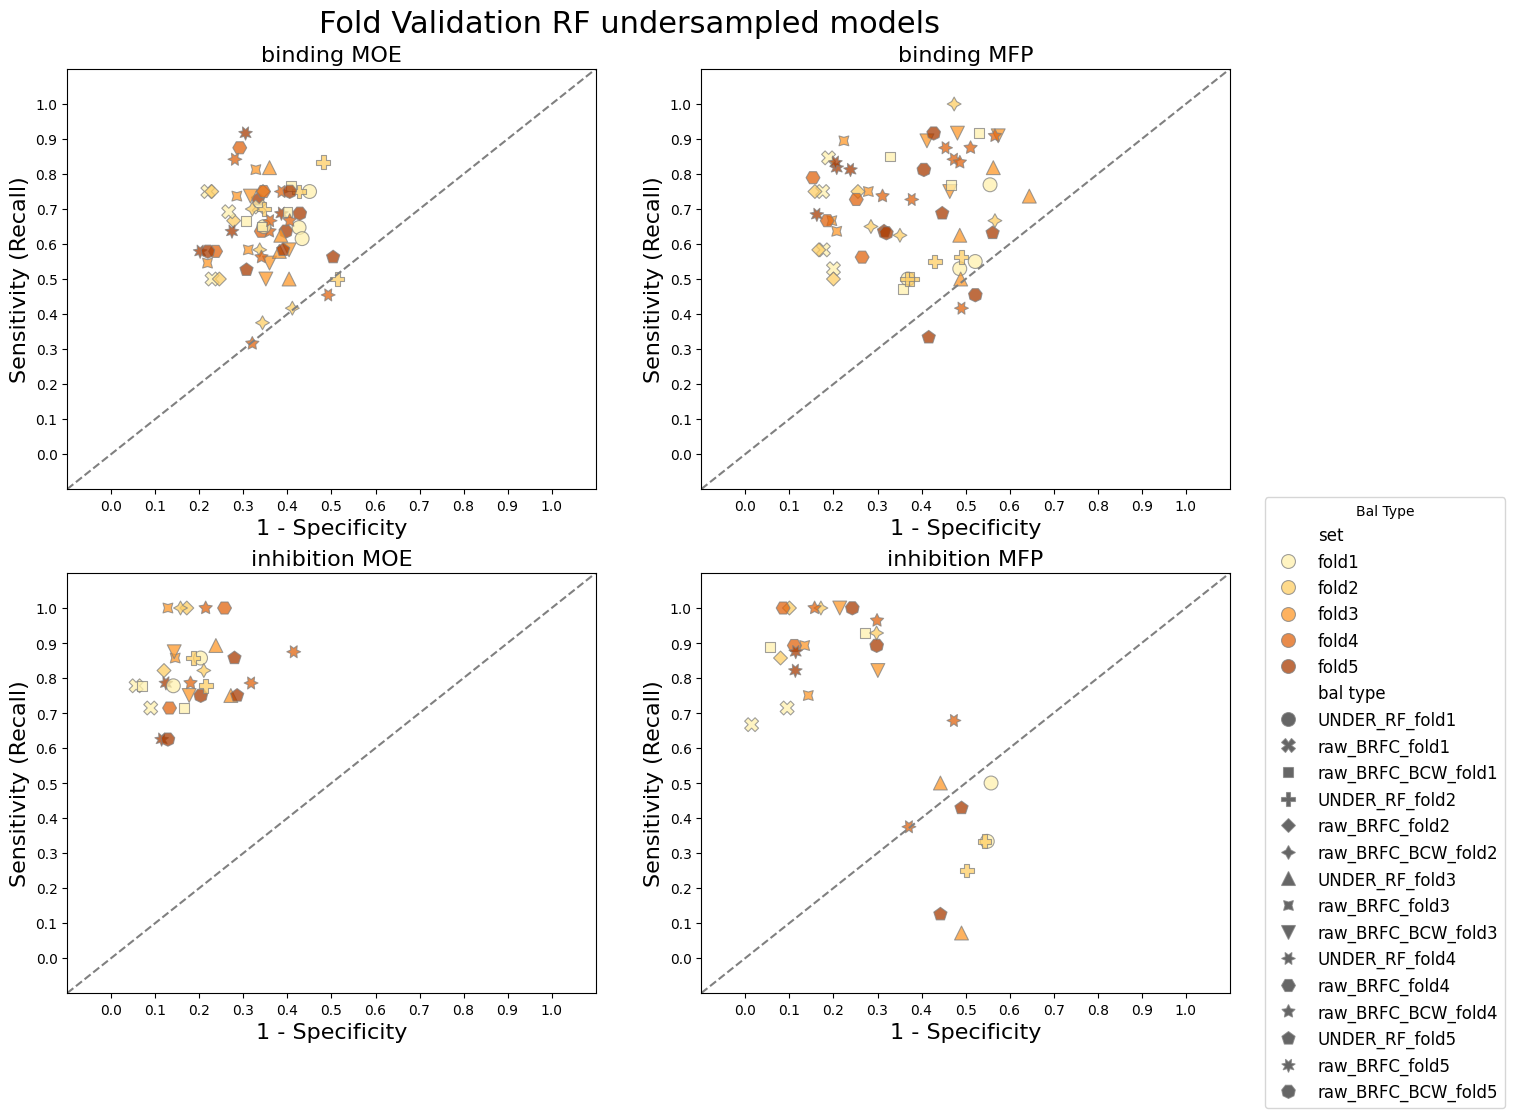

In [15]:
special_palette4 = {'raw_RF': 'cornflowerblue', 'raw_RF_BCW': 'cyan', 
                   'raw_BRFC': 'blue', 'raw_BRFC_BCW': 'black', 
                   'UNDER_RF': 'tab:orange', 'ADASYN_RF': 'tab:red', 
                   'raw_GP':'cornflowerblue', 'UNDER_GP':'tab:orange', 'ADASYN_GP':'tab:red' }
unique_cats = fold_bind['set'].nunique()
ylobr = sns.color_palette("YlOrBr", n_colors=unique_cats)
fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([fold_bind,fold_inhib])): 
    moe_df =this_df[this_df['feat_type'] == 'moe']
    mfp_df = this_df[this_df['feat_type'] == 'mfp']
    
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='set',style='bal type',
                   alpha=0.75, palette=ylobr,s=100, edgecolor='gray', ax=axs[i,0])
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='set',style='bal type',
                   alpha=0.75, palette=ylobr,s=100,legend=True, ax=axs[i,1],edgecolor='gray')
    
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i, j].legend_.remove()
    axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axs[i, 0].set_title(f'{moe_df["nek type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{moe_df["nek type"].iloc[0]} MFP', fontsize=16)
plt.suptitle('Fold Validation RF undersampled models', fontsize=22, y=.93)
plt.savefig('fold1to5_undersampled_RF.png',bbox_inches='tight')

raw_BRFC_fold1
raw_BRFC_fold2
raw_BRFC_fold3
raw_BRFC_fold4
raw_BRFC_fold5
raw_BRFC_BCW_fold1
raw_BRFC_BCW_fold2
raw_BRFC_BCW_fold3
raw_BRFC_BCW_fold4
raw_BRFC_BCW_fold5


/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_14831/1912549054.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.4))


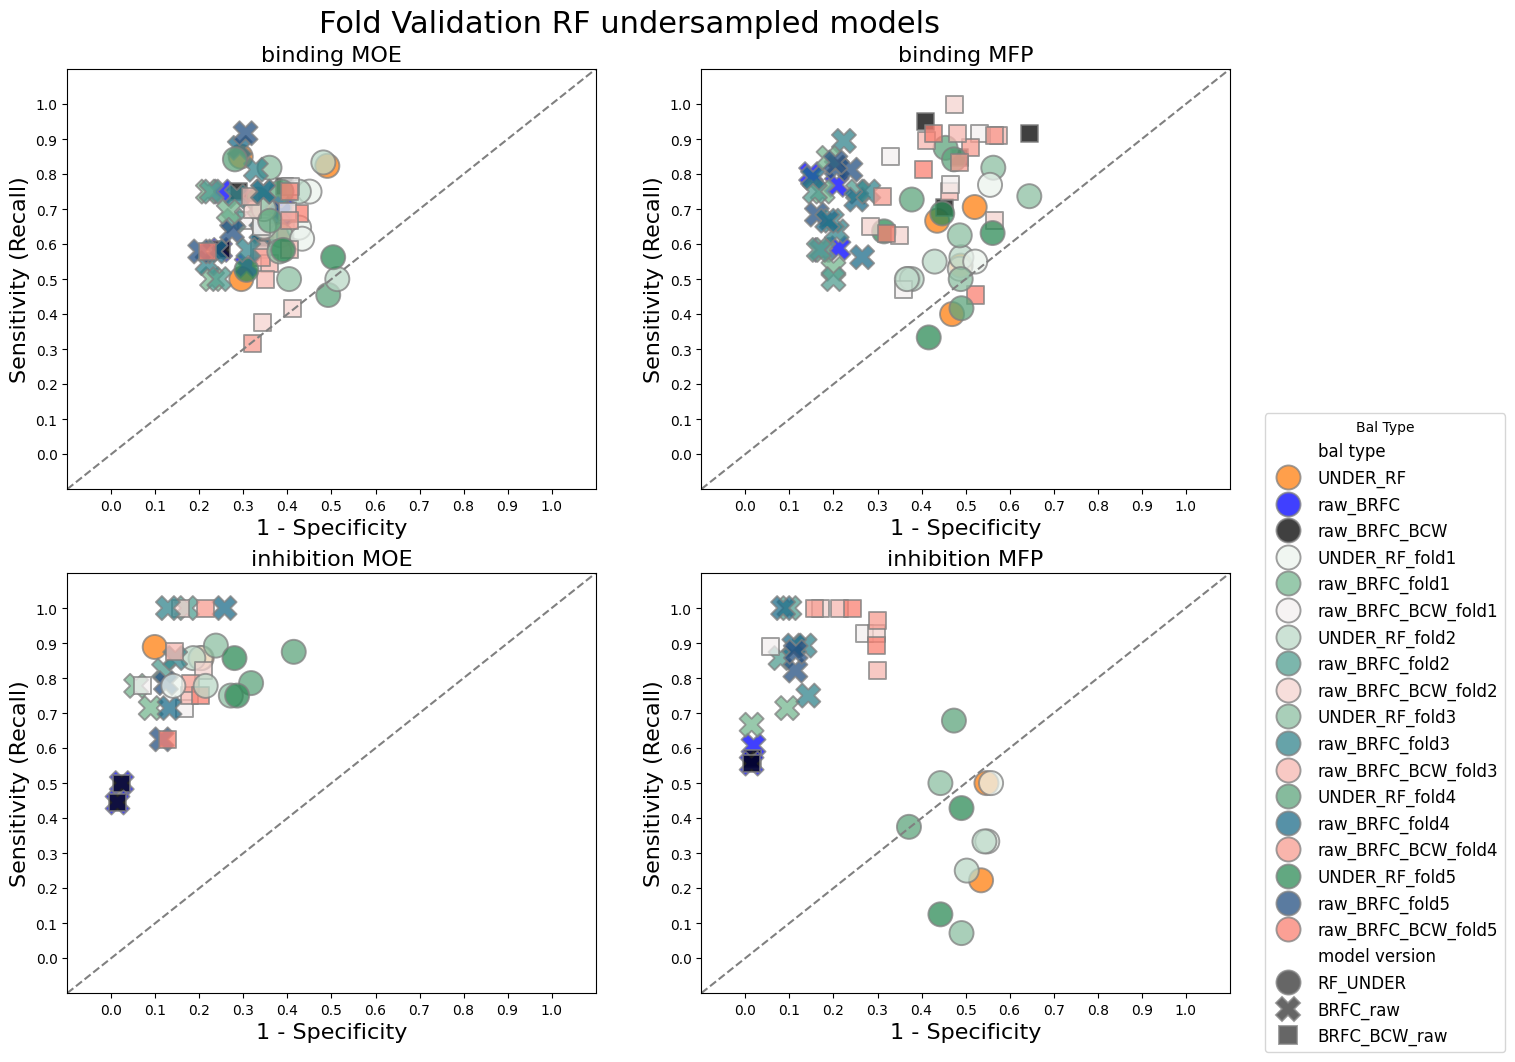

In [18]:
comparison_us['model version'] = comparison_us['RF_type'].astype(str)+'_'+comparison_us['strategy'] 
bind2 = comparison_us[comparison_us['nek type'] =='binding']
inhib2 = comparison_us[comparison_us['nek type'] =='inhibition'] 
special_palette5 = {'raw_RF': 'cornflowerblue', 'raw_RF_BCW': 'cyan', 
                   'raw_BRFC': 'blue', 'raw_BRFC_BCW': 'black', 
                   'UNDER_RF': 'tab:orange', 'ADASYN_RF': 'tab:red', 
                   'raw_GP':'cornflowerblue', 'UNDER_GP':'tab:orange', 'ADASYN_GP':'tab:red'}
comparison_us['bal type'].unique()
# lst_folds = ['UNDER_RF_fold3', 'raw_BRFC_fold3', 'UNDER_RF', 'raw_BRFC_fold2',
#        'raw_BRFC_BCW_fold2', 'raw_BRFC', 'raw_BRFC_BCW', 'UNDER_RF_fold1',
#        'raw_BRFC_fold1', 'raw_BRFC_BCW_fold1', 'UNDER_RF_fold2',
#        'raw_BRFC_BCW_fold3', 'UNDER_RF_fold4', 'raw_BRFC_fold4',
#        'raw_BRFC_BCW_fold4', 'UNDER_RF_fold5', 'raw_BRFC_fold5',
#        'raw_BRFC_BCW_fold5']
lst_folds = ['UNDER_RF_fold1', 'raw_BRFC_fold1', 'raw_BRFC_BCW_fold1','UNDER_RF_fold2', 'raw_BRFC_fold2', 'raw_BRFC_BCW_fold2', 
             'UNDER_RF_fold3', 'raw_BRFC_fold3', 'raw_BRFC_BCW_fold3', 'UNDER_RF_fold4', 'raw_BRFC_fold4', 'raw_BRFC_BCW_fold4',
             'UNDER_RF_fold5', 'raw_BRFC_fold5', 'raw_BRFC_BCW_fold5']
under_folds = ['UNDER_RF_fold1', 'UNDER_RF_fold2','UNDER_RF_fold3','UNDER_RF_fold4','UNDER_RF_fold5']
import matplotlib.colors as mcolors
yellows = sns.color_palette("YlOrBr", n_colors=5)
yellows = sns.light_palette("seagreen",n_colors=5)
hex_colors_yellows = [mcolors.to_hex(color) for color in yellows]
under_folds = ['UNDER_RF_fold1','UNDER_RF_fold2','UNDER_RF_fold3','UNDER_RF_fold4','UNDER_RF_fold5']
for color,strat in zip(hex_colors_yellows,under_folds): 
    special_palette5[strat] = color 

BRFC_folds = ['raw_BRFC_fold1','raw_BRFC_fold2','raw_BRFC_fold3','raw_BRFC_fold4','raw_BRFC_fold5']
blues= sns.color_palette("crest", n_colors=5)
hex_colors_BRFC = [mcolors.to_hex(color) for color in blues]
for color,strat in zip(hex_colors_BRFC,BRFC_folds): 
    print(strat)
    special_palette5[strat] = color 

BRFC_BCW_folds = ['raw_BRFC_BCW_fold1','raw_BRFC_BCW_fold2','raw_BRFC_BCW_fold3','raw_BRFC_BCW_fold4','raw_BRFC_BCW_fold5']
pinks = sns.color_palette("light:salmon", n_colors=5)
hex_colors_BRFC_BCW = [mcolors.to_hex(color) for color in pinks]
for color,strat in zip(hex_colors_BRFC_BCW,BRFC_BCW_folds): 
    print(strat)
    special_palette5[strat] = color 

fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([bind2,inhib2])): 
    moe_df =this_df[this_df['feat_type'] == 'moe']
    mfp_df = this_df[this_df['feat_type'] == 'mfp']
    
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='bal type', style='model version',
                   alpha=0.75, palette=special_palette5,s=300, edgecolor='gray', ax=axs[i,0])
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='bal type',style='model version',
                   alpha=0.75, palette=special_palette5,s=300,legend=True, ax=axs[i,1],edgecolor='gray')
    
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i, j].legend_.remove()
    axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.4))
    
    axs[i, 0].set_title(f'{moe_df["nek type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{moe_df["nek type"].iloc[0]} MFP', fontsize=16)
plt.suptitle('Fold Validation RF undersampled models', fontsize=22, y=.93)
plt.savefig('fold1to5_undersampled_all_RFtypes.png',bbox_inches='tight')

# try just RF models 


/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_14831/502166189.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))


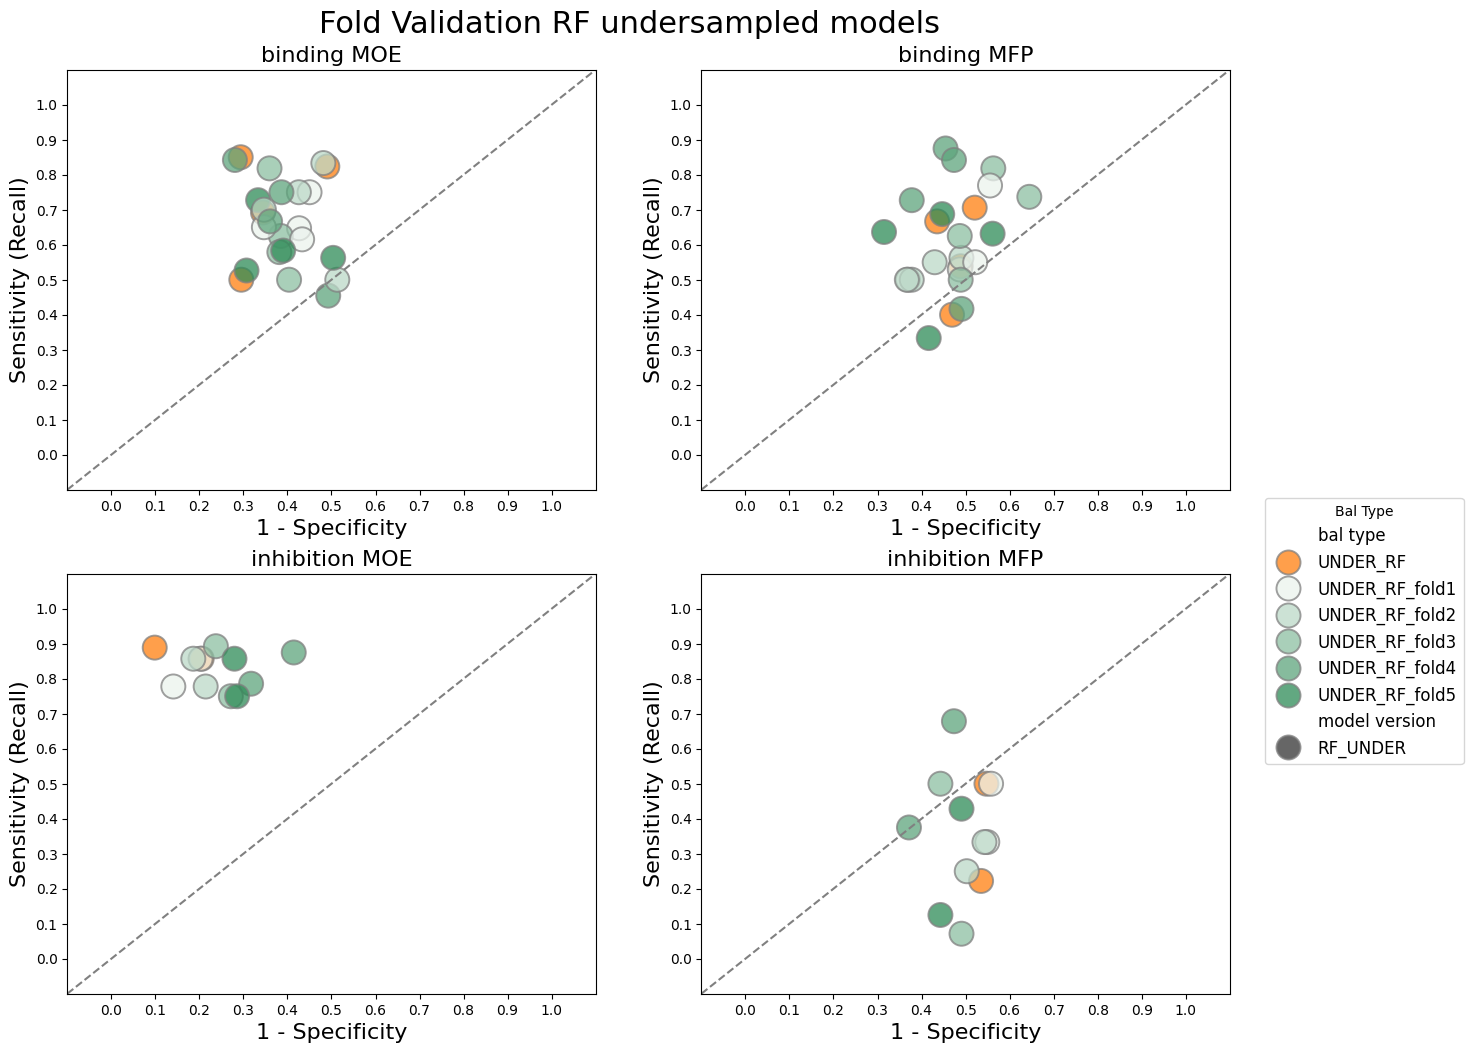

In [19]:
fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([bind2,inhib2])): 
    this_df = this_df[this_df['RF_type'] =='RF']
    moe_df =this_df[this_df['feat_type'] == 'moe']
    mfp_df = this_df[this_df['feat_type'] == 'mfp']
    # print('moe') 
    # print(moe_df['bal type'].value_counts())
    # print('mfp') 
    # print(mfp_df['bal type'].value_counts())
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='bal type', style='model version',
                   alpha=0.75, palette=special_palette5,s=300, edgecolor='gray', ax=axs[i,0])
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='bal type',style='model version',
                   alpha=0.75, palette=special_palette5,s=300,legend=True, ax=axs[i,1],edgecolor='gray')
    
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i, j].legend_.remove()
    axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axs[i, 0].set_title(f'{moe_df["nek type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{moe_df["nek type"].iloc[0]} MFP', fontsize=16)
plt.suptitle('Fold Validation RF undersampled models', fontsize=22, y=.93)
plt.savefig('fold1to5_undersampled_RF_only.png',bbox_inches='tight')

# BRFC

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_14831/2310725070.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))


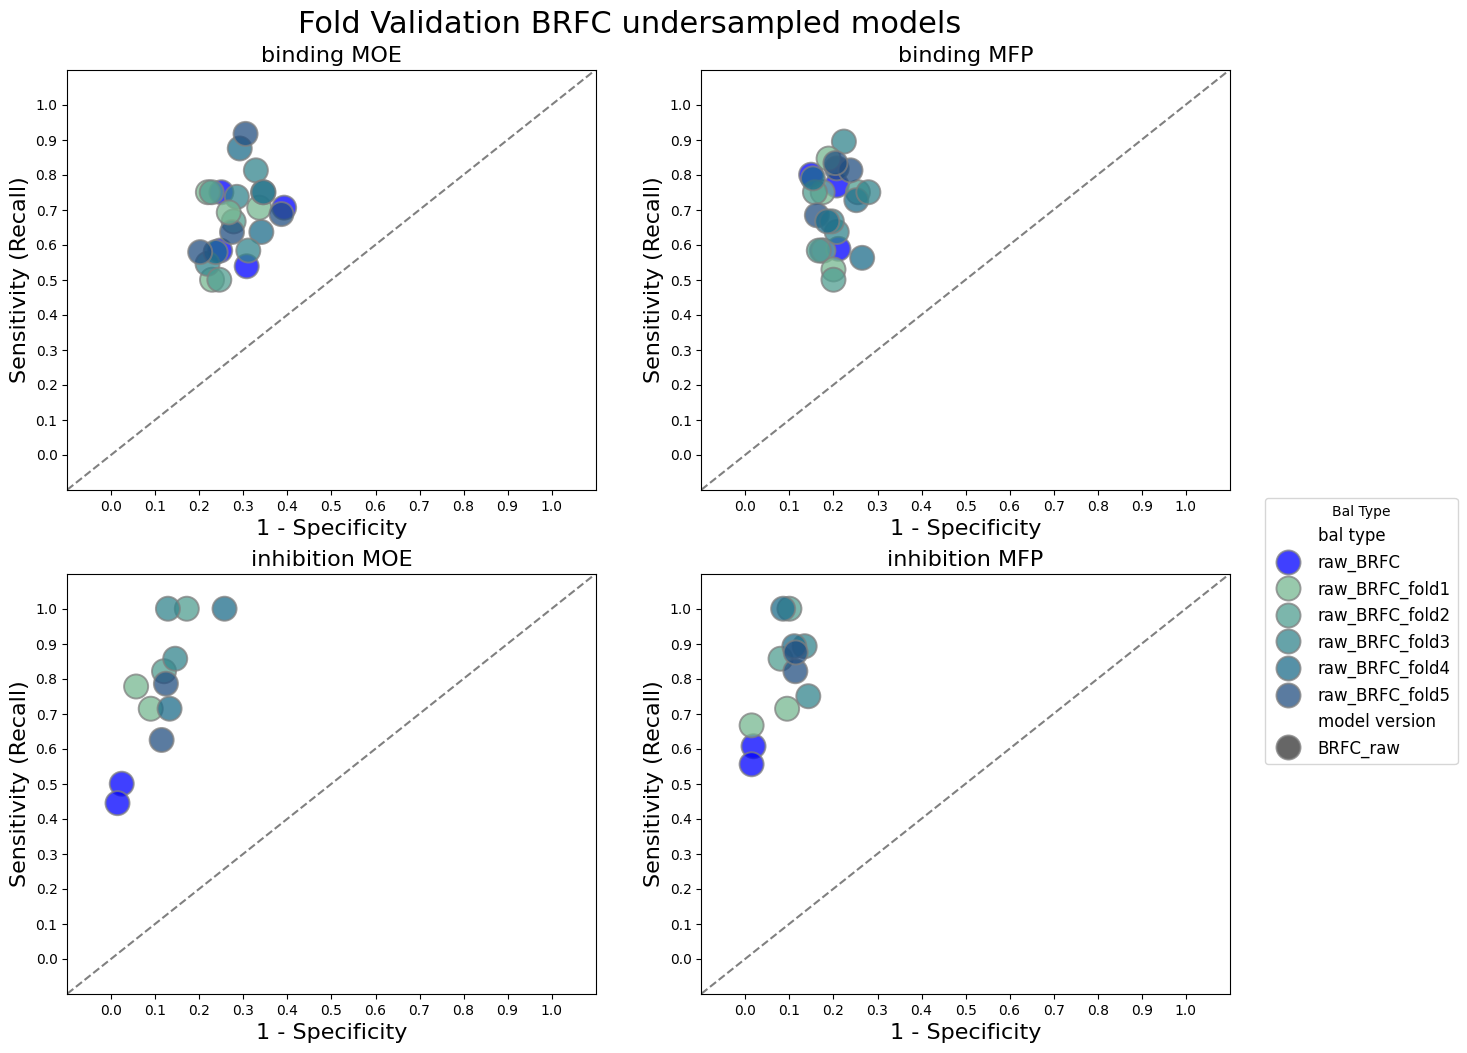

In [20]:
fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([bind2,inhib2])): 
    this_df = this_df[this_df['RF_type'] =='BRFC']
    moe_df =this_df[this_df['feat_type'] == 'moe']
    mfp_df = this_df[this_df['feat_type'] == 'mfp']
    # print('moe') 
    # print(moe_df['bal type'].value_counts())
    # print('mfp') 
    # print(mfp_df['bal type'].value_counts())
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='bal type', style='model version',
                   alpha=0.75, palette=special_palette5,s=300, edgecolor='gray', ax=axs[i,0])
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='bal type',style='model version',
                   alpha=0.75, palette=special_palette5,s=300,legend=True, ax=axs[i,1],edgecolor='gray')
    
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i, j].legend_.remove()
    axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axs[i, 0].set_title(f'{moe_df["nek type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{moe_df["nek type"].iloc[0]} MFP', fontsize=16)
plt.suptitle('Fold Validation BRFC undersampled models', fontsize=22, y=.93)
plt.savefig('fold1to5_undersampled_BRFC.png',bbox_inches='tight')

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_14831/26786098.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))


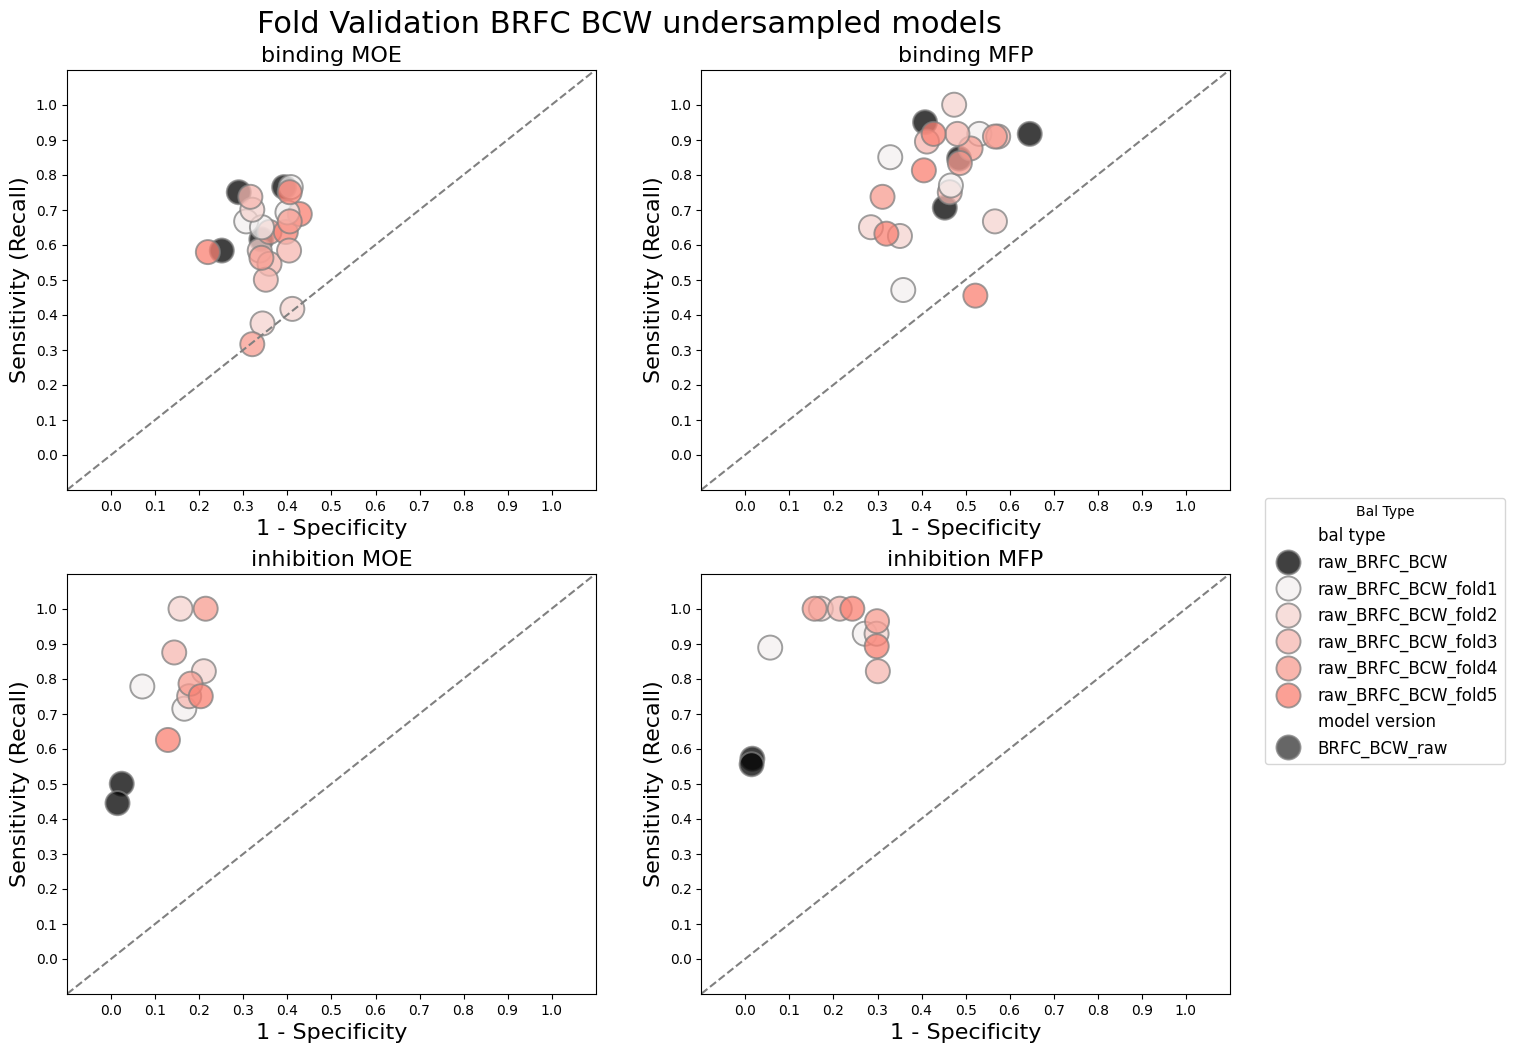

In [21]:
fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([bind2,inhib2])): 
    this_df = this_df[this_df['RF_type'] =='BRFC_BCW']
    moe_df =this_df[this_df['feat_type'] == 'moe']
    mfp_df = this_df[this_df['feat_type'] == 'mfp']
    
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='bal type', style='model version',
                   alpha=0.75, palette=special_palette5,s=300, edgecolor='gray', ax=axs[i,0])
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='bal type',style='model version',
                   alpha=0.75, palette=special_palette5,s=300,legend=True, ax=axs[i,1],edgecolor='gray')
    
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i, j].legend_.remove()
    axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axs[i, 0].set_title(f'{moe_df["nek type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{moe_df["nek type"].iloc[0]} MFP', fontsize=16)
plt.suptitle('Fold Validation BRFC BCW undersampled models', fontsize=22, y=.93)
plt.savefig('fold1to5_undersampled_BRFC_BCW.png',bbox_inches='tight')